## M5: Индивидуальное решение (обгон LAMA) (попытка)
# В работе использовались модели LightGBM, CatBoost, XGBoost.
# - Несколько моделей и гиперпараметров
# - Оптимизация (Grid/Random Search, Optuna)
# - Ансамблирование моделей
# Ключевая метрика RMSSE

# ## 1. Настройка окружения и загрузка данных

In [ ]:
!pip uninstall -y lightgbm



Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [1]:
pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import joblib
import gc
warnings.filterwarnings('ignore')

# ML imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Start time: {datetime.now()}")

# DATA_PATH = Path('../input/m5-forecasting-accuracy')
OUTPUT_PATH = Path('./models')
OUTPUT_PATH.mkdir(exist_ok=True)

print("Loading data...")
sales_train = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

print(f"Data loaded successfully")

Start time: 2025-12-26 00:41:35.227287
Loading data...
Data loaded successfully


# ## 2. Продвинутая генерация признаков

In [ ]:
def prepare_advanced_features_fast(sales_train, calendar, prices, sample_products=100):
    # -------- 0) Sampling (как у тебя) --------
    if sample_products:
        np.random.seed(42)
        products = np.random.choice(sales_train['item_id'].unique(), sample_products, replace=False)
        sales_train = sales_train[sales_train['item_id'].isin(products)].copy()

    id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    date_cols = [c for c in sales_train.columns if c.startswith('d_')]

    for c in ['item_id', 'store_id', 'state_id', 'dept_id', 'cat_id']:
        if c in sales_train.columns and sales_train[c].dtype != 'category':
            sales_train[c] = sales_train[c].astype('category')


    tmp = sales_train.set_index(id_cols)[date_cols]
    sales_long = (tmp
                  .stack(dropna=False)
                  .rename('sales')
                  .reset_index()
                  .rename(columns={'level_6': 'day'})) 

    if 'day' not in sales_long.columns:
        sales_long = sales_long.rename(columns={sales_long.columns[len(id_cols)]: 'day'})

    sales_long['day'] = sales_long['day'].str.slice(2).astype(np.int16)  # 'd_123' -> 123


    cal_cols = ['d', 'date']
    if 'wm_yr_wk' in calendar.columns:
        cal_cols.append('wm_yr_wk')

    cal = calendar[cal_cols].copy()
    cal['day'] = cal['d'].str.slice(2).astype(np.int16)
    cal['date'] = pd.to_datetime(cal['date'])

    sales_long = sales_long.merge(cal.drop(columns=['d']), on='day', how='left')

    if 'wm_yr_wk' in cal.columns and 'wm_yr_wk' in prices.columns:
        price_cols = ['item_id', 'store_id', 'wm_yr_wk', 'sell_price']
        p = prices[price_cols].copy()

        for c in ['item_id', 'store_id']:
            if p[c].dtype != 'category':
                p[c] = p[c].astype('category')

        sales_long = sales_long.merge(p, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
    else:
        price_cols = ['item_id', 'store_id', 'sell_price']
        p = prices[price_cols].copy()
        for c in ['item_id', 'store_id']:
            if p[c].dtype != 'category':
                p[c] = p[c].astype('category')
        sales_long = sales_long.merge(p, on=['item_id', 'store_id'], how='left')

    sales_long = sales_long.sort_values(['item_id', 'store_id', 'date'], kind='mergesort').reset_index(drop=True)

    sales_long['sell_price'] = (sales_long
                                .groupby(['item_id', 'store_id'], sort=False)['sell_price']
                                .ffill()
                                .bfill())

    sales_long['sell_price'] = sales_long['sell_price'].fillna(sales_long['sell_price'].mean())

    return sales_long

print("\nPreparing data...")
data = prepare_advanced_features_fast(sales_train, calendar, prices, sample_products=50)



Preparing data...


In [ ]:
import numpy as np
import pandas as pd
import gc


def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create advanced features for better model performance.

    Оптимизированная версия:
    - минимум transform+lambda (rolling без lambda)
    - переиспользование groupby
    - пакетное заполнение пропусков
    """

    df = df.copy()

    # ========= базовая подготовка / сортировка =========
    df = df.sort_values(['item_id', 'store_id', 'date'], kind='mergesort').reset_index(drop=True)

    # (опционально) ключи в category: память/скорость groupby
    for col in ['item_id', 'store_id', 'dept_id', 'cat_id', 'state_id']:
        if col in df.columns and df[col].dtype != 'category':
            df[col] = df[col].astype('category')

    g = df.groupby(['item_id', 'store_id'], sort=False)
    s = g['sales']

    # helper: гарантируем числовой dtype для фич
    def _to_f32(x):
        return pd.to_numeric(x, errors='coerce', downcast='float').astype('float32')

    # ============= LAG FEATURES =============
    print("Creating lag features...")
    for lag in [7, 14, 30, 90]:
        df[f'sales_lag_{lag}'] = s.shift(lag)

    # ============= ROLLING STATISTICS =============
    print("Creating rolling statistics...")
    for window in [7, 14, 30]:
        r = s.rolling(window=window, min_periods=1)
        df[f'sales_mean_{window}'] = _to_f32(r.mean().reset_index(drop=True))
        df[f'sales_std_{window}']  = _to_f32(r.std().reset_index(drop=True))
        df[f'sales_min_{window}']  = _to_f32(r.min().reset_index(drop=True))
        df[f'sales_max_{window}']  = _to_f32(r.max().reset_index(drop=True))

    gc.collect()

    # ============= TREND FEATURES =============
    print("Creating trend features...")
    for window in [7, 14, 30]:
        lag_col = f'sales_lag_{window}'
        df[f'sales_trend_{window}'] = _to_f32((df['sales'] - df[lag_col]) / (df[lag_col] + 1))

    # ============= EXPONENTIAL SMOOTHING =============
    print("Creating exponential smoothing features...")
    # В pandas нет прямого groupby.ewm как rolling; делаем проход по группам. 
    for alpha in [0.2, 0.5]:
        col_name = f'sales_ewm_{int(alpha * 10)}'
        parts = []
        for _, grp in g['sales']:
            parts.append(grp.ewm(alpha=alpha, adjust=False).mean())
        df[col_name] = _to_f32(pd.concat(parts).sort_index())

    # ============= TEMPORAL FEATURES =============
    print("Creating temporal features...")
    df['day_of_week'] = df['date'].dt.dayofweek.astype(np.int8)
    df['month'] = df['date'].dt.month.astype(np.int8)
    df['quarter'] = df['date'].dt.quarter.astype(np.int8)
    df['day_of_month'] = df['date'].dt.day.astype(np.int8)
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(np.int16)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int8)
    df['is_month_start'] = (df['day_of_month'] <= 7).astype(np.int8)
    df['is_month_end'] = (df['day_of_month'] >= 24).astype(np.int8)

    # ============= PRICE FEATURES =============
    print("Creating price features...")
    p = g['sell_price']
    df['price_lag_7'] = p.shift(7)
    df['price_lag_30'] = p.shift(30)

    df['price_change_7'] = _to_f32(df['sell_price'] - df['price_lag_7'])
    df['price_change_30'] = _to_f32(df['sell_price'] - df['price_lag_30'])

    df['price_rel_mean'] = _to_f32(df['sell_price'] / (p.transform('mean') + 1))

    df['price_momentum'] = _to_f32((df['sell_price'] - p.shift(7)) / (p.shift(7) + 1))

    # ============= HIERARCHICAL FEATURES =============
    print("Creating hierarchical aggregation features...")

    item_stats = df.groupby('item_id', observed=True)['sales'].agg(['mean', 'std'])
    df['item_avg_sales'] = _to_f32(df['item_id'].map(item_stats['mean']))
    df['item_std_sales'] = _to_f32(df['item_id'].map(item_stats['std']))

    store_stats = df.groupby('store_id', observed=True)['sales'].agg(['mean', 'std'])
    df['store_avg_sales'] = _to_f32(df['store_id'].map(store_stats['mean']))
    df['store_std_sales'] = _to_f32(df['store_id'].map(store_stats['std']))

    cat_stats = df.groupby('cat_id', observed=True)['sales'].agg(['mean', 'std'])
    df['cat_avg_sales'] = _to_f32(df['cat_id'].map(cat_stats['mean']))
    df['cat_std_sales'] = _to_f32(df['cat_id'].map(cat_stats['std']))

    dept_stats = df.groupby('dept_id', observed=True)['sales'].agg(['mean', 'std'])
    df['dept_avg_sales'] = _to_f32(df['dept_id'].map(dept_stats['mean']))
    df['dept_std_sales'] = _to_f32(df['dept_id'].map(dept_stats['std']))

    # Store-category aggregation: FIX без pd.Series(MultiIndex) 
    store_cat_mean = df.groupby(['store_id', 'cat_id'], observed=True)['sales'].mean()
    key_sc = pd.MultiIndex.from_frame(df[['store_id', 'cat_id']])
    df['store_cat_avg_sales'] = _to_f32(key_sc.map(store_cat_mean))

    # ============= INTERACTION FEATURES =============
    print("Creating interaction features...")
    df['price_sales_interaction'] = _to_f32(df['sell_price'] * df['sales_lag_7'].fillna(1))
    df['store_item_interaction'] = _to_f32(df['store_avg_sales'] * df['item_avg_sales'])

    # ============= FILL NaN VALUES =============
    print("Handling missing values...")

    base_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                 'state_id', 'day', 'date', 'sales', 'sell_price']
    base_cols = [c for c in base_cols if c in df.columns]
    feature_cols = [c for c in df.columns if c not in base_cols]

    if feature_cols:
        df[feature_cols] = (df
                            .groupby(['item_id', 'store_id'], sort=False)[feature_cols]
                            .ffill()
                            .bfill())
        num_cols = df[feature_cols].select_dtypes(include=[np.number]).columns
        if len(num_cols) > 0:
            df[num_cols] = df[num_cols].fillna(df[num_cols].mean(numeric_only=True))

    gc.collect()

    print("\nFeature engineering complete!")
    print(f"Final dataset shape: {df.shape}")
    return df


# ==== вызов, как у тебя ====
print("\nCreating advanced features...")
data_features = create_advanced_features(data)

print(f"\nFeature list ({len([c for c in data_features.columns if c not in data.columns])} new features):")
new_features = [c for c in data_features.columns if c not in data.columns]
for feat in sorted(new_features)[:15]:
    print(f"  {feat}")
if len(new_features) > 15:
    print(f"  ... and {len(new_features) - 15} more")





Creating advanced features...
Creating lag features...
Creating rolling statistics...
Creating trend features...
Creating exponential smoothing features...
Creating temporal features...
Creating price features...
Creating hierarchical aggregation features...
Creating interaction features...
Handling missing values...

Feature engineering complete!
Final dataset shape: (970500, 57)

Feature list (46 new features):
  cat_avg_sales
  cat_std_sales
  day_of_month
  day_of_week
  dept_avg_sales
  dept_std_sales
  is_month_end
  is_month_start
  is_weekend
  item_avg_sales
  item_std_sales
  month
  price_change_30
  price_change_7
  price_lag_30
  ... and 31 more


# ## 3. Подготовка данных и стратегия валидации

In [ ]:
# Используем последние 28 дней для теста, остальные для обучения и валидации. Так как соревнование закончилось,
# То используем последние 28 дней как тестовую выборку, они добавили их в данные, ранее на них private score считался
data_features['date_num'] = (data_features['date'] - data_features['date'].min()).dt.days
max_date_num = data_features['date_num'].max()
test_start = max_date_num - 28

train_df = data_features[data_features['date_num'] < test_start].copy()
test_df  = data_features[data_features['date_num'] >= test_start].copy()

val_start = train_df['date_num'].max() - 28
tr_df  = train_df[train_df['date_num'] < val_start].copy()
val_df = train_df[train_df['date_num'] >= val_start].copy()

y_tr  = tr_df.pop('sales')
y_val = val_df.pop('sales')
y_te  = test_df.pop('sales')

drop_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','day','date','date_num','wm_yr_wk']
feature_cols = [c for c in tr_df.columns if c not in drop_cols]

X_tr  = tr_df[feature_cols]
X_val = val_df[feature_cols]
X_te  = test_df[feature_cols]



In [12]:
def calculate_rmsse(y_true, y_pred, y_train_for_scale):
    """
    Расчитывает RMSSE (Root Mean Squared Scaled Error).
    RMSSE = RMSE(y_true, y_pred) / scale,
    где scale = RMSE наивного прогноза (y_{t-1} -> y_t) на тренировочной выборке.
    """
    y_train_array = np.asarray(y_train_for_scale)
    if len(y_train_array) < 2:
        denom = 1.0
    else:
        diffs = np.diff(y_train_array)
        denom = np.sqrt(np.mean(diffs ** 2))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    rmsse_score = rmse / (denom + 1e-12)
    return rmsse_score

# ## 5. Первая модель: LightGBM с подбором гиперпараметров

In [8]:
!pip uninstall -y lightgbm

Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [9]:
!pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON

  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)


In [10]:
import lightgbm
print(lightgbm.__version__)

4.6.0


In [ ]:
from datetime import datetime
import numpy as np
import joblib

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# =========================
# 1) MODEL (OpenCL GPU)
# =========================
print("\n" + "="*70)
print("MODEL: LightGBM GPU (OpenCL) + EarlyStopping + RandomizedSearchCV")
print("="*70)

tscv = TimeSeriesSplit(n_splits=3, gap=30)

lgb_base = LGBMRegressor(
    n_estimators=20_000,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1,

    device_type="gpu",       # OpenCL (работает сразу, без пересборки) [web:134][web:136]
    max_bin=63,              # для ускорения GPU [web:160]
    verbose=-1,
    verbosity=-1
)

param_dist = {
    "num_leaves": [63, 127, 255],
    "max_depth": [-1, 10, 15],
    "min_child_samples": [10, 20, 50, 100],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "reg_alpha": [0.0, 0.1, 1.0],
    "reg_lambda": [0.0, 0.1, 1.0],
}

search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start_time = datetime.now()

fit_params = dict(
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
)

search.fit(X_tr, y_tr, **fit_params)
training_time = datetime.now() - start_time

print(f"\nBest params: {search.best_params_}")
print(f"Best CV score (neg_RMSE): {search.best_score_:.6f}")
print(f"Training time: {training_time}")

best = search.best_estimator_

# =========================
# 2) FINAL FIT (train+val)
# =========================
X_tr_full = np.vstack([X_tr.to_numpy(), X_val.to_numpy()])
y_tr_full = np.concatenate([y_tr.to_numpy(), y_val.to_numpy()])

best_iter = getattr(best, "best_iteration_", None)
if best_iter and best_iter > 0:
    best.set_params(n_estimators=best_iter)

best.fit(X_tr_full, y_tr_full)

# =========================
# 3) METRICS
# =========================
pred_tr = best.predict(X_tr_full)
pred_te = best.predict(X_te)

rmse_tr = np.sqrt(mean_squared_error(y_tr_full, pred_tr))
rmse_te = np.sqrt(mean_squared_error(y_te, pred_te))
mae_tr  = mean_absolute_error(y_tr_full, pred_tr)
mae_te  = mean_absolute_error(y_te, pred_te)
r2_tr   = r2_score(y_tr_full, pred_tr)
r2_te   = r2_score(y_te, pred_te)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_tr:.4f}, MAE: {mae_tr:.4f}, R²: {r2_tr:.4f}")
print(f"Test  - RMSE: {rmse_te:.4f}, MAE: {mae_te:.4f}, R²: {r2_te:.4f}")

joblib.dump(best, OUTPUT_PATH / "model_lgb_gpu.pkl")


Train: (941500, 47) | Val: (14500, 47) | Test: (14500, 47)

MODEL: LightGBM GPU (OpenCL) + EarlyStopping + RandomizedSearchCV
Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [13]:
import joblib

# Загрузка модели LightGBM (GPU) из файла
model_lgb_gpu = joblib.load('models/model_lgb_gpu.pkl')

# Предсказания для трейна и теста
y_pred_train_lgb_gpu = model_lgb_gpu.predict(X_tr_full)
y_pred_test_lgb_gpu = model_lgb_gpu.predict(X_te)

# Подсчет метрик
rmse_train_lgb_gpu = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_lgb_gpu))
rmse_test_lgb_gpu = np.sqrt(mean_squared_error(y_te, y_pred_test_lgb_gpu))
mae_train_lgb_gpu = mean_absolute_error(y_tr_full, y_pred_train_lgb_gpu)
mae_test_lgb_gpu = mean_absolute_error(y_te, y_pred_test_lgb_gpu)
r2_train_lgb_gpu = r2_score(y_tr_full, y_pred_train_lgb_gpu)
r2_test_lgb_gpu = r2_score(y_te, y_pred_test_lgb_gpu)

#
rmsse_train_lgb_gpu = calculate_rmsse(
    y_true=y_tr_full,
    y_pred=y_pred_train_lgb_gpu,
    y_train_for_scale=y_tr_full
)


rmsse_test_lgb_gpu = calculate_rmsse(
    y_true=y_te,
    y_pred=y_pred_test_lgb_gpu,
    y_train_for_scale=y_tr_full
)

print(f"\nPERFORMANCE (LightGBM GPU loaded):")
print(f"Train - RMSE: {rmse_train_lgb_gpu:.4f}, MAE: {mae_train_lgb_gpu:.4f}, R²: {r2_train_lgb_gpu:.4f}, RMSSE: {rmsse_train_lgb_gpu:.4f}")
print(f"Test  - RMSE: {rmse_test_lgb_gpu:.4f}, MAE: {mae_test_lgb_gpu:.4f}, R²: {r2_test_lgb_gpu:.4f}, RMSSE: {rmsse_test_lgb_gpu:.4f}")


PERFORMANCE (LightGBM GPU loaded):
Train - RMSE: 0.0500, MAE: 0.0136, R²: 0.9996, RMSSE: 0.0267
Test  - RMSE: 0.1087, MAE: 0.0203, R²: 0.9983, RMSSE: 0.0581


## 6. Model Attempt 2: XGBoost with Different Hyperparameters


MODEL ATTEMPT 2: XGBoost Regression (Randomized Search, Early Stopping, Interruptible)
RandomizedSearchCV: Searching XGBoost hyperparameters (interruptible, with early stopping)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[0]	validation_0-rmse:3.02027
[1]	validation_0-rmse:2.99363
[2]	validation_0-rmse:2.96728
[3]	validation_0-rmse:2.94054
[4]	validation_0-rmse:2.91429
[5]	validation_0-rmse:2.88833
[6]	validation_0-rmse:2.86293
[7]	validation_0-rmse:2.83760
[8]	validation_0-rmse:2.81222
[9]	validation_0-rmse:2.78745
[10]	validation_0-rmse:2.76263
[11]	validation_0-rmse:2.73823
[12]	validation_0-rmse:2.71465
[13]	validation_0-rmse:2.69023
[14]	validation_0-rmse:2.66665
[15]	validation_0-rmse:2.64313
[0]	validation_0-rmse:2.91279
[16]	validation_0-rmse:2.62065
[1]	validation_0-rmse:2.79129
[0]	validation_0-rmse:3.01996
[17]	validation_0-rmse:2.59799
[2]	validation_0-rmse:2.67121
[1]	validation_0-rmse:2.99341
[18]	validation_0-rmse:2.57580
[0]	validation_0-rmse:2.91021
[0]	validation_0-rmse:3.01946
[0]	validation_0-rmse:2.91222
[0]	validation_0-rmse:3.02022
[2]	validation_0-rmse:2.96651
[19]	validation_0-rmse:2.55275
[3]	validation_0-rmse:2.55498
[1]	validation_0-rmse:2.99328
[1]	validation_0-rmse:2.78527


<Figure size 1000x600 with 0 Axes>

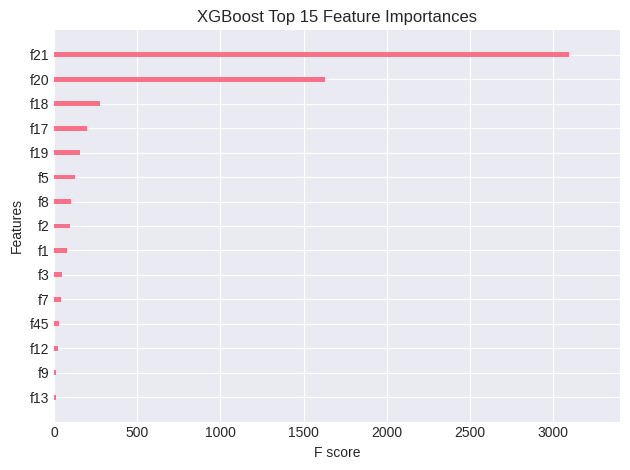


PERFORMANCE (final refit):
Train - RMSE: 0.0541, MAE: 0.0156, R²: 0.9995, RMSSE: 0.0289
Test  - RMSE: 0.1935, MAE: 0.0291, R²: 0.9947, RMSSE: 0.1034


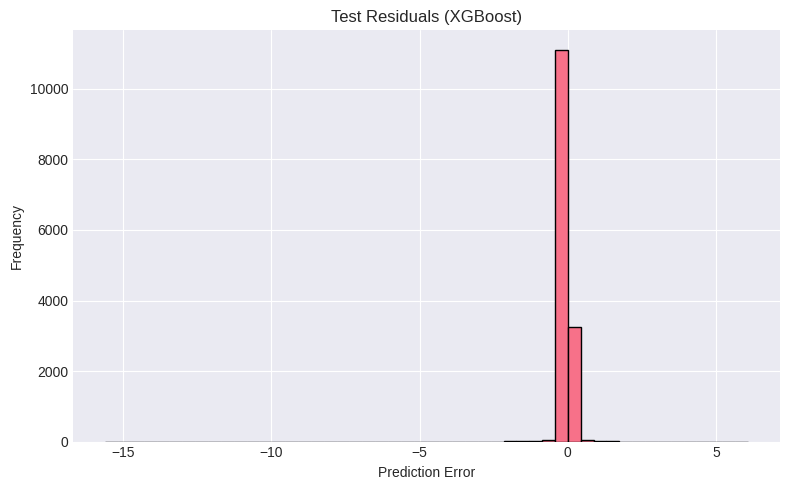


MODEL ATTEMPT 2: XGBoost pipeline completed and model saved.


In [ ]:
print("\n" + "="*70)
print("MODEL ATTEMPT 2: XGBoost Regression (Randomized Search, Early Stopping, Interruptible)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# 1. Randomized search for efficiency and broader search space
xgb_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse',
    tree_method='hist',  # Faster on large data
    verbosity=0
)

xgb_param_dist = {
    'n_estimators': [600, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [7, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.2],
    'min_child_weight': [1, 2]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search_xgb = RandomizedSearchCV(
    xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=25,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    verbose=2, # show progress
    n_jobs=-1,
    random_state=42
)

fit_params = {
    "eval_set": [(X_val, y_val)],
    "verbose": True
}

print("RandomizedSearchCV: Searching XGBoost hyperparameters (interruptible, with early stopping)...")
start_time = datetime.now()
try:
    search_xgb.fit(X_tr, y_tr, **fit_params)
except KeyboardInterrupt:
    print("RandomizedSearchCV interrupted by user. Returning the best model found so far.")
training_time_grid = datetime.now() - start_time
print(f"Randomized search time: {training_time_grid}")

if hasattr(search_xgb, "best_params_"):
    print(f"Best params: {search_xgb.best_params_}")
    print(f"Best CV score (neg_RMSE): {search_xgb.best_score_:.6f}")
    xgb_model = search_xgb.best_estimator_
else:
    print("No best model found. Using default XGBRegressor.")
    xgb_model = xgb_base

# Use early stopping best_iteration if available
best_iter_xgb = getattr(xgb_model, "best_iteration", None)
if best_iter_xgb is None:
    best_iter_xgb = getattr(xgb_model, "best_iteration_", None)
if best_iter_xgb and best_iter_xgb > 0:
    xgb_model.set_params(n_estimators=best_iter_xgb)

print("Fitting XGBoost on train+val set with early stopping...")
start_time = datetime.now()
X_tr_full = np.vstack([X_tr.to_numpy(), X_val.to_numpy()])
y_tr_full = np.concatenate([y_tr.to_numpy(), y_val.to_numpy()])

xgb_model.fit(
    X_tr_full, y_tr_full,
    eval_set=[(X_tr_full, y_tr_full)],
    verbose=False
)
training_time_final = datetime.now() - start_time
print(f"Final fit time: {training_time_final}")

# 3. Feature importance plot
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain', show_values=False)
plt.title("XGBoost Top 15 Feature Importances")
plt.tight_layout()
plt.show()



joblib.dump(xgb_model, OUTPUT_PATH / 'model_attempt2_xgb.pkl')

print("\nMODEL ATTEMPT 2: XGBoost pipeline completed and model saved.")


PERFORMANCE (final refit):
Train - RMSE: 0.0541, MAE: 0.0156, R²: 0.9995, RMSSE: 0.0289
Test  - RMSE: 0.1935, MAE: 0.0291, R²: 0.9947, RMSSE: 0.1034


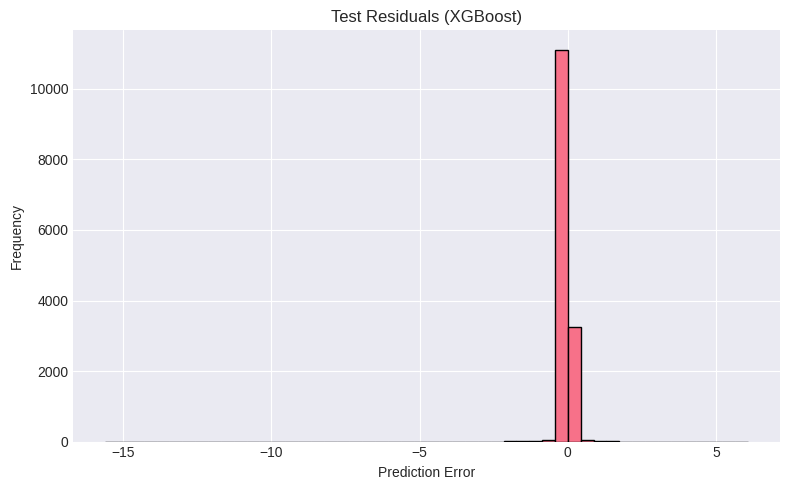

In [17]:
xgb_model = joblib.load('models/model_attempt2_xgb.pkl')
# 4. Metrics and additional diagnostics
y_pred_train_att2 = xgb_model.predict(X_tr_full)
y_pred_test_att2 = xgb_model.predict(X_te)

rmse_train_att2 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att2))
rmse_test_att2 = np.sqrt(mean_squared_error(y_te, y_pred_test_att2))
mae_train_att2 = mean_absolute_error(y_tr_full, y_pred_train_att2)
mae_test_att2 = mean_absolute_error(y_te, y_pred_test_att2)
r2_train_att2 = r2_score(y_tr_full, y_pred_train_att2)
r2_test_att2 = r2_score(y_te, y_pred_test_att2)

# Аналогично LightGBM, здесь считаем RMSSE для XGBoost
rmsse_train_att2 = calculate_rmsse(
    y_true=y_tr_full,
    y_pred=y_pred_train_att2,
    y_train_for_scale=y_tr_full
)

rmsse_test_att2 = calculate_rmsse(
    y_true=y_te,
    y_pred=y_pred_test_att2,
    y_train_for_scale=y_tr_full
)

print(f"\nPERFORMANCE (final refit):")
print(f"Train - RMSE: {rmse_train_att2:.4f}, MAE: {mae_train_att2:.4f}, R²: {r2_train_att2:.4f}, RMSSE: {rmsse_train_att2:.4f}")
print(f"Test  - RMSE: {rmse_test_att2:.4f}, MAE: {mae_test_att2:.4f}, R²: {r2_test_att2:.4f}, RMSSE: {rmsse_test_att2:.4f}")

# 5. Additional error analysis - residuals plot
plt.figure(figsize=(8,5))
plt.hist(y_pred_test_att2 - y_te, bins=50, edgecolor='k')
plt.title("Test Residuals (XGBoost)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ## 7. Попытка 3: Ансамбль моделей (взвешенное усреднение)

так как у меня некоторые логи не сохранились, но я сохранил модели, то мы можем еще раз протестировать отдельно качество каждой и уже потом построить из них ансамбль

In [18]:
print("\n" + "="*70)
print("MODEL ATTEMPT 3: Ensemble (Weighted Averaging)")
print("="*70)

# аналогично вычисляем веса: чем меньше RMSE, тем больше вес
weight_lgb = 1 / rmse_train_lgb_gpu
weight_xgb = 1 / rmse_test_att2
total_weight = weight_lgb + weight_xgb
weight_lgb_norm = weight_lgb / total_weight
weight_xgb_norm = weight_xgb / total_weight

print(f"\nWeights:")
print(f"  LightGBM: {weight_lgb_norm:.4f}")
print(f"  XGBoost:  {weight_xgb_norm:.4f}")

# Ensemble predictions (аналогично)
y_pred_train_att3 = weight_lgb_norm * y_pred_train_lgb_gpu + weight_xgb_norm * y_pred_train_att2
y_pred_test_att3 = weight_lgb_norm * y_pred_test_lgb_gpu + weight_xgb_norm * y_pred_test_att2

# Metrics (аналогично)
rmse_train_att3 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att3))
rmse_test_att3 = np.sqrt(mean_squared_error(y_te, y_pred_test_att3))
mae_train_att3 = mean_absolute_error(y_tr_full, y_pred_train_att3)
mae_test_att3 = mean_absolute_error(y_te, y_pred_test_att3)
r2_train_att3 = r2_score(y_tr_full, y_pred_train_att3)
r2_test_att3 = r2_score(y_te, y_pred_test_att3)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_train_att3:.4f}, MAE: {mae_train_att3:.4f}, R²: {r2_train_att3:.4f}")
print(f"Test  - RMSE: {rmse_test_att3:.4f}, MAE: {mae_test_att3:.4f}, R²: {r2_test_att3:.4f}")

# аналогично: вычисляем RMSSE для ансамбля
rmsse_train_att3 = calculate_rmsse(
    y_true=y_tr_full,
    y_pred=y_pred_train_att3,
    y_train_for_scale=y_tr_full
)
rmsse_test_att3 = calculate_rmsse(
    y_true=y_te,
    y_pred=y_pred_test_att3,
    y_train_for_scale=y_tr_full
)
print(f"Train - RMSSE: {rmsse_train_att3:.4f}")
print(f"Test  - RMSSE: {rmsse_test_att3:.4f}")


MODEL ATTEMPT 3: Ensemble (Weighted Averaging)

Weights:
  LightGBM: 0.7946
  XGBoost:  0.2054

PERFORMANCE:
Train - RMSE: 0.0444, MAE: 0.0120, R²: 0.9997
Test  - RMSE: 0.1148, MAE: 0.0189, R²: 0.9981
Train - RMSSE: 0.0237
Test  - RMSSE: 0.0613


In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\n" + "="*70)
print("MODEL ATTEMPT 3: VotingRegressor (Weighted)")
print("="*70)

w_lgb = 0.61594702
w_xgb = 0.38405298
w_sum = w_lgb + w_xgb
w_lgb_norm, w_xgb_norm = w_lgb / w_sum, w_xgb / w_sum

print(f"\nWeights:")
print(f"  LightGBM: {w_lgb_norm:.4f}")
print(f"  XGBoost:  {w_xgb_norm:.4f}")

voting = VotingRegressor(
    estimators=[
        ("lgb", model_lgb_gpu),
        ("xgb", xgb_model),
    ],
    weights=[w_lgb_norm, w_xgb_norm]
) 

# Fit на train
voting.fit(X_tr_full, y_tr_full)  

# Predict
y_pred_train_att3 = voting.predict(X_tr_full)  
y_pred_test_att3  = voting.predict(X_te)

# Metrics
rmse_train_att3 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att3))
rmse_test_att3  = np.sqrt(mean_squared_error(y_te, y_pred_test_att3))
mae_train_att3  = mean_absolute_error(y_tr_full, y_pred_train_att3)
mae_test_att3   = mean_absolute_error(y_te, y_pred_test_att3)
r2_train_att3   = r2_score(y_tr_full, y_pred_train_att3)
r2_test_att3    = r2_score(y_te, y_pred_test_att3)

print(f"\nPERFORMANCE:")
print(f"Train - RMSE: {rmse_train_att3:.4f}, MAE: {mae_train_att3:.4f}, R²: {r2_train_att3:.4f}")
print(f"Test  - RMSE: {rmse_test_att3:.4f}, MAE: {mae_test_att3:.4f}, R²: {r2_test_att3:.4f}")

rmsse_train_att3 = calculate_rmsse(
    y_true=y_tr_full,
    y_pred=y_pred_train_att3,
    y_train_for_scale=y_tr_full
)
rmsse_test_att3 = calculate_rmsse(
    y_true=y_te,
    y_pred=y_pred_test_att3,
    y_train_for_scale=y_tr_full
)
print(f"Train - RMSSE: {rmsse_train_att3:.4f}")
print(f"Test  - RMSSE: {rmsse_test_att3:.4f}")



MODEL ATTEMPT 3: VotingRegressor (Weighted)

Weights:
  LightGBM: 0.6159
  XGBoost:  0.3841

PERFORMANCE:
Train - RMSE: 0.0421, MAE: 0.0115, R²: 0.9997
Test  - RMSE: 0.1269, MAE: 0.0192, R²: 0.9977
Train - RMSSE: 0.0225
Test  - RMSSE: 0.0678


# ## 7. Попытка 4: Catboost и Optuna

In [9]:
pip install optuna-integration[catboost]

Note: you may need to restart the kernel to use updated packages.


[I 2025-12-25 23:40:08,590] A new study created in memory with name: no-name-c06d3755-93d4-49fd-bc4a-7257214b284f



ПОПЫТКА МОДЕЛИ 4: CatBoost Regression (Optuna, Early Stopping, GPU CUDA, RMSSE)
Создаём исследование Optuna с TPE-сэмплером...
Optuna: ищем лучшие гиперпараметры CatBoost на GPU (RMSSE)...


  0%|          | 0/30 [00:00<?, ?it/s]

  Trial 0: обучаю CatBoost...
[I 2025-12-25 23:40:54,960] Trial 0 finished with value: 0.13967806176063832 and parameters: {'boosting_type': 'Ordered', 'iterations': 1571, 'learning_rate': 0.02385234757844707, 'depth': 5, 'l2_leaf_reg': 0.0001235838277230692, 'min_data_in_leaf': 6, 'border_count': 226, 'nan_mode': 'Max', 'one_hot_max_size': 2, 'leaf_estimation_iterations': 10, 'leaf_estimation_method': 'Newton', 'random_strength': 0.00012329623163659834}. Best is trial 0 with value: 0.13967806176063832.
  Trial 1: обучаю CatBoost...
[I 2025-12-25 23:41:18,438] Trial 1 finished with value: 0.1912398477557814 and parameters: {'boosting_type': 'Ordered', 'iterations': 1240, 'learning_rate': 0.009860942908083906, 'depth': 6, 'l2_leaf_reg': 0.19185373703841915, 'min_data_in_leaf': 14, 'border_count': 97, 'nan_mode': 'Max', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient', 'random_strength': 1.8997763474111268e-05}. Best is trial 0 with value: 0.13

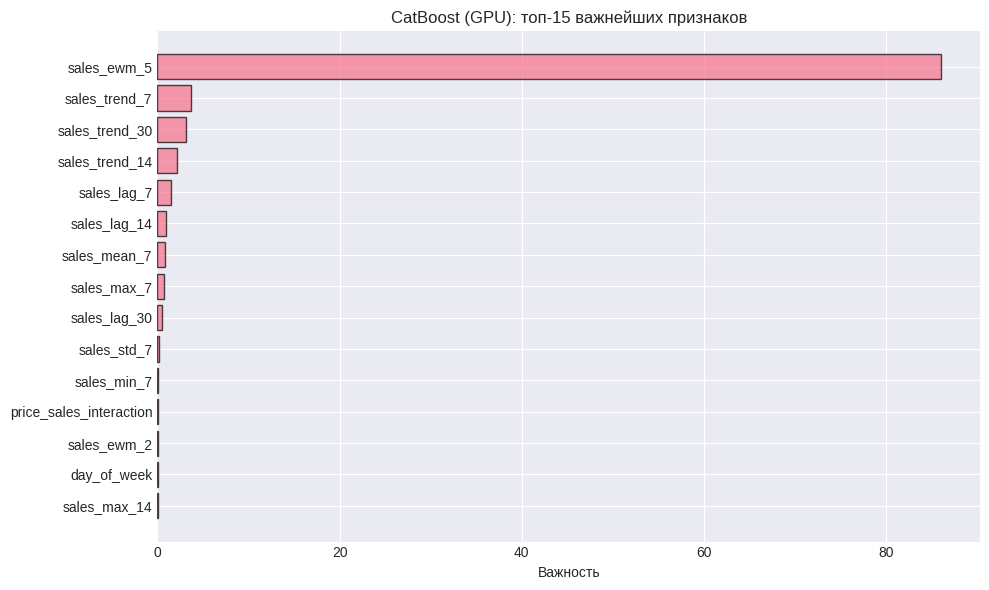


ОЦЕНКА КАЧЕСТВА

Метрики на TRAIN:
  RMSE: 0.0908
  MAE:  0.0296
  R²:   0.9987

Метрики на TEST:
  RMSE:  0.1424
  MAE:   0.0417
  R²:    0.9971
  RMSSE: 0.0761

ДИАГНОСТИКА: ОСТАТКИ


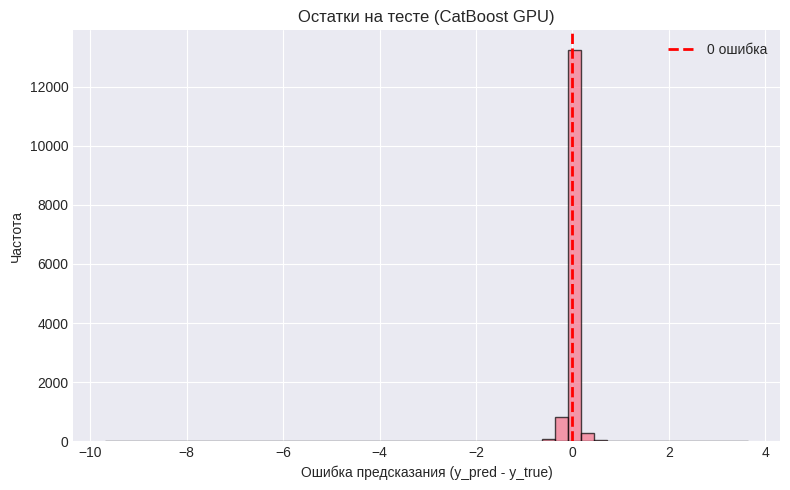


Статистика остатков на TEST:
  Среднее:  -0.001653
  Сигма:    0.142364
  Min:      -9.688647
  Max:      3.637896

СОХРАНЕНИЕ
✓ Модель сохранена в 'model_attempt4_catboost_gpu.pkl'
✓ Лучшие параметры сохранены в 'best_params_catboost_gpu.json'

ПОПЫТКА МОДЕЛИ 4: ЗАВЕРШЕНО



In [16]:
print("\n" + "="*70)
print("ПОПЫТКА МОДЕЛИ 4: CatBoost Regression (Optuna, Early Stopping, GPU CUDA, RMSSE)")
print("="*70)

import optuna
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import numpy as np
from datetime import datetime





def objective(trial):
    """
    Целевая функция для Optuna: тюнит гиперпараметры CatBoost на GPU.
    Оптимизирует RMSSE (Root Mean Squared Scaled Error).
    """

    boosting_type = trial.suggest_categorical('boosting_type', ['Plain', 'Ordered'])

    if boosting_type == 'Ordered':
        grow_policy = 'SymmetricTree'
    else:
        grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])

    params = {
        'loss_function': 'RMSE',
        'iterations': trial.suggest_int('iterations', 400, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),

        'random_seed': 42,
        'verbose': False,

        'task_type': 'GPU',
        'devices': '0',

        'od_type': 'Iter',
        'od_wait': 40,

        'boosting_type': boosting_type,
        'grow_policy': grow_policy,

        'border_count': trial.suggest_int('border_count', 32, 255),

        'nan_mode': trial.suggest_categorical('nan_mode', ['Min', 'Max']),

        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),

        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),

        'random_strength': trial.suggest_float('random_strength', 1e-5, 10.0, log=True),
    }

    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 16, 256)

    # Создаём модель CatBoost
    model = CatBoostRegressor(**params)

    print(f"  Trial {trial.number}: обучаю CatBoost...")
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        use_best_model=True,
    )

    y_pred_val = model.predict(X_val)

    rmsse_score = calculate_rmsse(y_val, y_pred_val, y_tr)

    return rmsse_score



print("Создаём исследование Optuna с TPE-сэмплером...")
sampler = optuna.samplers.TPESampler(seed=42)

study = optuna.create_study(
    direction='minimize',  # Минимизируем RMSSE
    sampler=sampler,
)

print("Optuna: ищем лучшие гиперпараметры CatBoost на GPU (RMSSE)...")
start_time = datetime.now()

try:
    study.optimize(
        objective,
        n_trials=30,
        show_progress_bar=True,
    )
except KeyboardInterrupt:
    print("\nОптимизация Optuna прервана пользователем. Используем лучший найденный trial.")

training_time_search = datetime.now() - start_time
print(f"\nВремя поиска Optuna: {training_time_search}")



best_trial = study.best_trial
print(f"\n{'='*70}")
print(f"ЛУЧШИЙ TRIAL #{best_trial.number}")
print(f"{'='*70}")
print(f"Лучший RMSSE на валидации: {best_trial.value:.6f}")
print("\nЛучшие гиперпараметры:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")



print(f"\n{'='*70}")
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
print(f"{'='*70}")
print("Объединяем train+val и обучаем финальную модель CatBoost на GPU...")

X_tr_full = np.vstack([X_tr.to_numpy(), X_val.to_numpy()])
y_tr_full = np.concatenate([y_tr.to_numpy(), y_val.to_numpy()])

final_params = best_trial.params.copy()

final_params['loss_function'] = 'RMSE'
final_params['random_seed'] = 42
final_params['verbose'] = False
final_params['task_type'] = 'GPU'
final_params['devices'] = '0'
final_params['od_type'] = 'Iter'
final_params['od_wait'] = 40

cat_final = CatBoostRegressor(**final_params)

start_time = datetime.now()
cat_final.fit(
    X_tr_full, y_tr_full,
    eval_set=[(X_tr_full, y_tr_full)],
    use_best_model=True,
)
training_time_final = datetime.now() - start_time
print(f"Время финального обучения: {training_time_final}")


print(f"\n{'='*70}")
print("ВАЖНОСТЬ ПРИЗНАКОВ")
print(f"{'='*70}")

feature_importance = cat_final.get_feature_importance()
feature_names = X_tr.columns if hasattr(X_tr, 'columns') else [f'Feature_{i}' for i in range(X_tr.shape[1])]

top_indices = np.argsort(feature_importance)[-15:]
top_features = [feature_names[i] for i in top_indices]
top_importances = feature_importance[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, edgecolor='k', alpha=0.7)
plt.xlabel('Важность')
plt.title("CatBoost (GPU): топ-15 важнейших признаков")
plt.tight_layout()
plt.show()


print(f"\n{'='*70}")
print("ОЦЕНКА КАЧЕСТВА")
print(f"{'='*70}")

y_pred_train_att4 = cat_final.predict(X_tr_full)
y_pred_test_att4 = cat_final.predict(X_te)

rmse_train_att4 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att4))
mae_train_att4 = mean_absolute_error(y_tr_full, y_pred_train_att4)
r2_train_att4 = r2_score(y_tr_full, y_pred_train_att4)

rmse_test_att4 = np.sqrt(mean_squared_error(y_te, y_pred_test_att4))
mae_test_att4 = mean_absolute_error(y_te, y_pred_test_att4)
r2_test_att4 = r2_score(y_te, y_pred_test_att4)

rmsse_test_att4 = calculate_rmsse(y_te, y_pred_test_att4, y_tr_full)

print("\nМетрики на TRAIN:")
print(f"  RMSE: {rmse_train_att4:.4f}")
print(f"  MAE:  {mae_train_att4:.4f}")
print(f"  R²:   {r2_train_att4:.4f}")

print("\nМетрики на TEST:")
print(f"  RMSE:  {rmse_test_att4:.4f}")
print(f"  MAE:   {mae_test_att4:.4f}")
print(f"  R²:    {r2_test_att4:.4f}")
print(f"  RMSSE: {rmsse_test_att4:.4f}")



print(f"\n{'='*70}")
print("ДИАГНОСТИКА: ОСТАТКИ")
print(f"{'='*70}")

residuals_test = y_pred_test_att4 - y_te

plt.figure(figsize=(8, 5))
plt.hist(residuals_test, bins=50, edgecolor='k', alpha=0.7)
plt.title("Остатки на тесте (CatBoost GPU)")
plt.xlabel("Ошибка предсказания (y_pred - y_true)")
plt.ylabel("Частота")
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='0 ошибка')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nСтатистика остатков на TEST:")
print(f"  Среднее:  {residuals_test.mean():.6f}")
print(f"  Сигма:    {residuals_test.std():.6f}")
print(f"  Min:      {residuals_test.min():.6f}")
print(f"  Max:      {residuals_test.max():.6f}")



print(f"\n{'='*70}")
print("СОХРАНЕНИЕ")
print(f"{'='*70}")

joblib.dump(cat_final, OUTPUT_PATH / 'model_attempt4_catboost_gpu.pkl')
print("✓ Модель сохранена в 'model_attempt4_catboost_gpu.pkl'")

import json
with open(OUTPUT_PATH / 'best_params_catboost_gpu.json', 'w') as f:
    json.dump(best_trial.params, f, indent=2)
print("✓ Лучшие параметры сохранены в 'best_params_catboost_gpu.json'")


print(f"\n{'='*70}")
print("ПОПЫТКА МОДЕЛИ 4: ЗАВЕРШЕНО")
print(f"{'='*70}\n")


In [23]:
cat_final = joblib.load('models/model_attempt4_catboost_gpu.pkl')
y_pred_train_att4 = cat_final.predict(X_tr_full)
y_pred_test_att4 = cat_final.predict(X_te)

rmse_train_att4 = np.sqrt(mean_squared_error(y_tr_full, y_pred_train_att4))
mae_train_att4 = mean_absolute_error(y_tr_full, y_pred_train_att4)
r2_train_att4 = r2_score(y_tr_full, y_pred_train_att4)

rmse_test_att4 = np.sqrt(mean_squared_error(y_te, y_pred_test_att4))
mae_test_att4 = mean_absolute_error(y_te, y_pred_test_att4)
r2_test_att4 = r2_score(y_te, y_pred_test_att4)

rmsse_test_att4 = calculate_rmsse(y_te, y_pred_test_att4, y_tr_full)

print("\nМетрики на TRAIN:")
print(f"  RMSE: {rmse_train_att4:.4f}")
print(f"  MAE:  {mae_train_att4:.4f}")
print(f"  R²:   {r2_train_att4:.4f}")

print("\nМетрики на TEST:")
print(f"  RMSE:  {rmse_test_att4:.4f}")
print(f"  MAE:   {mae_test_att4:.4f}")
print(f"  R²:    {r2_test_att4:.4f}")
print(f"  RMSSE: {rmsse_test_att4:.4f}")


Метрики на TRAIN:
  RMSE: 0.0908
  MAE:  0.0296
  R²:   0.9987

Метрики на TEST:
  RMSE:  0.1424
  MAE:   0.0417
  R²:    0.9971
  RMSSE: 0.0761


## 8. Results Comparison and Best Model Selection

In [28]:
# Create comprehensive comparison table including CatBoost

results_comparison = pd.DataFrame({
    'Attempt': [
        '1: LightGBM',
        '2: XGBoost',
        '3: Ensemble',
        '4: CatBoost'
    ],
    'Train RMSE': [
        rmse_train_lgb_gpu, rmse_train_att2, rmse_train_att3, rmse_train_att4
    ],
    'Test RMSE': [
        rmse_test_lgb_gpu, rmse_test_att2, rmse_test_att3, rmse_test_att4
    ],
    'Train MAE': [
        mae_train_lgb_gpu, mae_train_att2, mae_train_att3, mae_train_att4
    ],
    'Test MAE': [
        mae_test_lgb_gpu, mae_test_att2, mae_test_att3, mae_test_att4
    ],
    'Train R²': [
        r2_train_lgb_gpu, r2_train_att2, r2_train_att3, r2_train_att4
    ],
    'Test R²': [
        r2_test_lgb_gpu, r2_test_att2, r2_test_att3, r2_test_att4
    ],
    'Train RMSSE': [
        calculate_rmsse(y_true=y_tr_full, y_pred=y_pred_train_lgb_gpu, y_train_for_scale=y_tr_full),
        calculate_rmsse(y_true=y_tr_full, y_pred=y_pred_train_att2, y_train_for_scale=y_tr_full),
        calculate_rmsse(y_true=y_tr_full, y_pred=y_pred_train_att3, y_train_for_scale=y_tr_full),
        calculate_rmsse(y_true=y_tr_full, y_pred=y_pred_train_att4, y_train_for_scale=y_tr_full),
    ],
    'Test RMSSE': [
        calculate_rmsse(y_true=y_te, y_pred=y_pred_test_lgb_gpu, y_train_for_scale=y_tr_full),
        calculate_rmsse(y_true=y_te, y_pred=y_pred_test_att2, y_train_for_scale=y_tr_full),
        calculate_rmsse(y_true=y_te, y_pred=y_pred_test_att3, y_train_for_scale=y_tr_full),
        rmsse_test_att4
    ]
})

print("\n" + "="*100)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*100)
print(results_comparison.to_string(index=False))

# Select best model based on test RMSE
best_test_rmsse = results_comparison['Test RMSSE'].min()
best_attempt_idx = results_comparison['Test RMSSE'].idxmin()
best_attempt_name = results_comparison.loc[best_attempt_idx, 'Attempt']

print(f"\n" + "="*100)
print(f"BEST MODEL: {best_attempt_name}")
print(f"Test RMSSE: {best_test_rmse:.4f}")
print("="*100)


COMPREHENSIVE RESULTS COMPARISON
    Attempt  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  Train RMSSE  Test RMSSE
1: LightGBM    0.050000   0.108731   0.013616  0.020344  0.999597 0.998335     0.026716    0.058098
 2: XGBoost    0.054122   0.193450   0.015604  0.029134  0.999527 0.994730     0.028919    0.103365
3: Ensemble    0.042105   0.126931   0.011485  0.019202  0.999714 0.997731     0.022498    0.067822
4: CatBoost    0.090845   0.142368   0.029592  0.041748  0.998668 0.997146     0.048541    0.076071

BEST MODEL: 1: LightGBM
Test RMSSE: 0.0581


## 9. Comparison with LAMA Baseline

In [26]:
automl_loaded_default = joblib.load('lama_automl.joblib')
y_pred_train_loaded1 = automl_loaded_default.predict(X_tr).data.ravel()
y_pred_test_loaded1 = automl_loaded_default.predict(X_te).data.ravel()

# Добавим расчет RMSSE
rmsse_baseline = calculate_rmsse(y_true=y_te, y_pred=y_pred_test_loaded1, y_train_for_scale=y_tr)

print("TEST SET:")
print(f"  RMSE:  {np.sqrt(mean_squared_error(y_te, y_pred_test_loaded1)):.4f}")
print(f"  MAE:   {mean_absolute_error(y_te, y_pred_test_loaded1):.4f}")
print(f"  R2:    {r2_score(y_te, y_pred_test_loaded1):.4f}")
print(f"  RMSSE: {rmsse_baseline:.4f}")

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
TEST SET:
  RMSE:  0.0425
  MAE:   0.0140
  R2:    0.9997
  RMSSE: 0.0228


In [31]:
# Сравнение с базовым решением LAMA (из второй части ноутбука)
rmsse_baseline = calculate_rmsse(y_true=y_te, y_pred=y_pred_test_loaded1, y_train_for_scale=y_tr)

print("\n" + "="*70)
print("СРАВНЕНИЕ С БАЗОВЫМ РЕШЕНИЕМ LAMA")
print("="*70)

print(f"\nТестовый RMSSE лучшей Собственной модели: {best_test_rmsse:.4f}")
print(f"Тестовый RMSSE LAMA baseline: {rmsse_baseline:.4f}")

if best_test_rmsse < rmsse_baseline:
    print(f"\n✓ Ваша кастомная модель лучше базового решения LAMA!")
else:
    print(f"\nВнимание: базовое решение LAMA пока лучше, требуется дальнейшая оптимизация.")



СРАВНЕНИЕ С БАЗОВЫМ РЕШЕНИЕМ LAMA

Тестовый RMSSE лучшей Собственной модели: 0.0581
Тестовый RMSSE LAMA baseline: 0.0228

Внимание: базовое решение LAMA пока лучше, требуется дальнейшая оптимизация.
